# Week 4: Bayesian Decoding of Position from Neural Activity

This notebook introduces **neural decoding** - the inverse problem of inferring
what an animal is doing from its neural activity. While encoding models ask
"how does the brain represent position?", decoding asks "given neural activity,
where is the animal?"

We'll build a **Bayesian decoder** that uses place cell activity to estimate
the animal's position. This approach is foundational for understanding how
populations of neurons represent information and has practical applications in
brain-machine interfaces.

## The Decoding Problem

In Week 2, we estimated **place fields** - the spatial firing rate maps that
show where each neuron prefers to fire. The decoding problem inverts this:

- **Encoding**: Position → Neural activity (What is the firing rate at each location?)
- **Decoding**: Neural activity → Position (Where is the animal given these spikes?)

## Learning Objectives

By the end of this notebook, you will be able to:

1. Estimate place fields using histogram methods (the encoding model)
2. Understand and implement the Bayesian decoding algorithm
3. Handle numerical stability issues when computing likelihoods
4. Understand the role of time bins with no spikes in decoding
5. Evaluate decoder performance and understand what limits accuracy
6. Appreciate how bin size affects the bias-variance tradeoff

## Setup

In [1]:
# Install dependencies (required for Google Colab)
import subprocess
import sys

if "google.colab" in sys.modules:
    subprocess.check_call(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "-q",
            "pynwb",
            "hdmf",
            "dandi",
            "remfile",
            "h5py",
            "fsspec",
            "aiohttp",
            "requests",
        ]
    )

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from dandi.dandiapi import DandiAPIClient
from numpy.typing import NDArray
from pynwb import NWBHDF5IO
from pynwb.misc import Units
from remfile import File as RemoteFile
from scipy.ndimage import gaussian_filter

## Load Data from DANDI

We'll use the same dataset from Week 1: hippocampal recordings from the
Buzsáki Lab during spatial navigation on a figure-8 maze.

In [3]:
# Define the dataset location on DANDI
DANDISET_ID = "000059"
DANDISET_VERSION = "0.230907.2101"
ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb"
)

In [4]:
# Connect to DANDI and get the streaming URL
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    asset = dandiset.get_asset_by_path(ASSET_PATH)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"Streaming from: {s3_url[:80]}...")

Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/075/b32/075b32be-1c44-4e2f-8a91-3eeb...


In [5]:
# Open the NWB file for streaming
remote_file = RemoteFile(s3_url)
h5_file = h5py.File(remote_file, "r")
io = NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()

print(f"Session: {nwbfile.identifier}")

Session: 7931d1a7-09c5-457f-9f0a-22d952d8b818


## Extract Position and Spike Data

In [6]:
# Get position data from behavior module
behavior_module = nwbfile.processing["behavior"]

position_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "position" in name.lower()
)

spatial_series = next(iter(position_interface.spatial_series.values()))
position_data = spatial_series.data[:]
position_timestamps = spatial_series.timestamps[:]

x_position = position_data[:, 0]
y_position = position_data[:, 1]

print(f"Position data shape: {position_data.shape}")
print(f"Time range: {position_timestamps[0]:.1f} - {position_timestamps[-1]:.1f} s")

Position data shape: (198664, 3)
Time range: 6348.1 - 8003.6 s


In [7]:
# Get units and filter for good quality
units_df = nwbfile.units.to_dataframe()
good_unit_mask = units_df["quality"].isin(["good", "good2"])
good_unit_indices = np.where(good_unit_mask)[0]

print(f"Total units: {len(units_df)}")
print(f"Good quality units: {len(good_unit_indices)}")

Total units: 1509
Good quality units: 172


### Filtering for Putative Pyramidal Cells

The hippocampus contains two main cell types:

- **Pyramidal cells** (place cells): Low mean firing rate (typically < 5 Hz),
  but fire strongly (> 5 Hz peak) when the animal is in their place field
- **Interneurons**: High mean firing rate (> 5-10 Hz), fire broadly across space

For decoding, we want pyramidal cells because they have spatially localized
firing. Interneurons would add noise since they don't encode position well.

We'll filter based on mean firing rate, then verify place field quality after
computing the rate maps.

In [8]:
def get_spike_times_in_epoch(
    units_table: Units, unit_idx: int, epoch_start: float, epoch_end: float
) -> NDArray[np.floating]:
    """Extract spike times within a specified epoch.

    Parameters
    ----------
    units_table : pynwb.misc.Units
        NWB units table containing spike times
    unit_idx : int
        Index of the unit to extract
    epoch_start, epoch_end : float
        Start and end times of the epoch in seconds

    Returns
    -------
    np.ndarray
        Spike times within the epoch
    """
    spikes = units_table["spike_times"][unit_idx]
    mask = (spikes >= epoch_start) & (spikes <= epoch_end)
    return spikes[mask]


# Filter spikes to position tracking epoch only
epoch_start = position_timestamps.min()
epoch_end = position_timestamps.max()
epoch_duration = epoch_end - epoch_start

# First pass: get all good units and compute mean firing rates
spike_times_good = []
mean_rates = []

for idx in good_unit_indices:
    spikes = get_spike_times_in_epoch(nwbfile.units, idx, epoch_start, epoch_end)
    spike_times_good.append(spikes)
    mean_rates.append(len(spikes) / epoch_duration)

mean_rates = np.array(mean_rates)

# Filter for putative pyramidal cells: mean rate < 5 Hz
# (We'll also require peak rate > 5 Hz after computing place fields)
MAX_MEAN_RATE = 5.0  # Hz - exclude fast-spiking interneurons

pyramidal_mask = mean_rates < MAX_MEAN_RATE
pyramidal_indices = np.where(pyramidal_mask)[0]

# Keep only putative pyramidal cells
spike_times_all = [spike_times_good[i] for i in pyramidal_indices]
good_unit_indices_filtered = good_unit_indices[pyramidal_indices]

print(f"Units with mean rate < {MAX_MEAN_RATE} Hz: {len(spike_times_all)}")
print(f"Excluded as putative interneurons: {(~pyramidal_mask).sum()}")

# Show rate distribution
print(f"\nMean firing rate distribution (Hz):")
print(f"  Included: mean={mean_rates[pyramidal_mask].mean():.2f}, "
      f"max={mean_rates[pyramidal_mask].max():.2f}")
if (~pyramidal_mask).sum() > 0:
    print(f"  Excluded: mean={mean_rates[~pyramidal_mask].mean():.2f}, "
          f"min={mean_rates[~pyramidal_mask].min():.2f}")

Units with mean rate < 5.0 Hz: 148
Excluded as putative interneurons: 24

Mean firing rate distribution (Hz):
  Included: mean=1.07, max=4.91
  Excluded: mean=15.55, min=5.01


## Part 1: Building the Encoding Model (Place Fields)

Before we can decode, we need an **encoding model** that describes how each
neuron's firing rate depends on position. This is the same place field
estimation we did in Week 2, but now we'll think of it as the foundation
for decoding.

### The Poisson Likelihood

We model spike counts as following a **Poisson distribution**:

$$P(n \mid \lambda) = \frac{\lambda^n e^{-\lambda}}{n!}$$

where:
- $n$ is the observed spike count in a time bin
- $\lambda$ is the expected spike count (firing rate × bin duration)

The place field gives us $\lambda$ as a function of position:
$$\lambda(x) = f(x) \cdot \Delta t$$

where $f(x)$ is the firing rate (Hz) at position $x$ and $\Delta t$ is the
time bin duration.

### Spatial Binning Setup

In [9]:
# Define spatial bins for place field estimation
POS_BIN_SIZE = 3  # cm - spatial resolution of place fields

# Find the spatial extent of the data
min_x, max_x = np.nanmin(x_position), np.nanmax(x_position)
min_y, max_y = np.nanmin(y_position), np.nanmax(y_position)

# Create bin edges
x_bin_edges = np.arange(min_x, max_x + POS_BIN_SIZE, POS_BIN_SIZE)
y_bin_edges = np.arange(min_y, max_y + POS_BIN_SIZE, POS_BIN_SIZE)

# Bin centers for plotting
x_bin_centers = x_bin_edges[:-1] + POS_BIN_SIZE / 2
y_bin_centers = y_bin_edges[:-1] + POS_BIN_SIZE / 2

n_x_bins = len(x_bin_centers)
n_y_bins = len(y_bin_centers)

print(f"Spatial grid: {n_x_bins} x {n_y_bins} = {n_x_bins * n_y_bins} bins")
print(f"Bin size: {POS_BIN_SIZE} cm")

Spatial grid: 36 x 39 = 1404 bins
Bin size: 3 cm


### Computing Occupancy and Place Fields

In [10]:
def compute_occupancy(
    x_pos: NDArray[np.floating],
    y_pos: NDArray[np.floating],
    x_edges: NDArray[np.floating],
    y_edges: NDArray[np.floating],
    sampling_rate: float,
) -> NDArray[np.floating]:
    """Compute time spent in each spatial bin.

    Parameters
    ----------
    x_pos, y_pos : np.ndarray
        Position coordinates
    x_edges, y_edges : np.ndarray
        Bin edges for each dimension
    sampling_rate : float
        Position sampling rate in Hz

    Returns
    -------
    np.ndarray
        Occupancy time in seconds for each spatial bin
    """
    # Count samples in each bin
    occupancy_samples, _, _ = np.histogram2d(x_pos, y_pos, bins=[x_edges, y_edges])
    # Convert to time
    return occupancy_samples / sampling_rate


def compute_place_field(
    spike_times: NDArray[np.floating],
    x_pos: NDArray[np.floating],
    y_pos: NDArray[np.floating],
    pos_timestamps: NDArray[np.floating],
    x_edges: NDArray[np.floating],
    y_edges: NDArray[np.floating],
    occupancy: NDArray[np.floating],
) -> NDArray[np.floating]:
    """Compute firing rate map (place field) for a single neuron.

    Parameters
    ----------
    spike_times : np.ndarray
        Spike times in seconds (should already be filtered to epoch)
    x_pos, y_pos : np.ndarray
        Position coordinates
    pos_timestamps : np.ndarray
        Timestamps for position samples
    x_edges, y_edges : np.ndarray
        Bin edges for each dimension
    occupancy : np.ndarray
        Time spent in each bin (seconds)

    Returns
    -------
    np.ndarray
        Firing rate map in Hz
    """
    # Find position at each spike time using binary search
    spike_pos_idx = np.searchsorted(pos_timestamps, spike_times)
    spike_pos_idx = np.clip(spike_pos_idx, 0, len(pos_timestamps) - 1)

    x_at_spike = x_pos[spike_pos_idx]
    y_at_spike = y_pos[spike_pos_idx]

    # Count spikes in each spatial bin
    spike_counts, _, _ = np.histogram2d(x_at_spike, y_at_spike, bins=[x_edges, y_edges])

    # Compute firing rate: spikes / time
    with np.errstate(divide="ignore", invalid="ignore"):
        firing_rate = spike_counts / occupancy
        # Set unvisited locations to zero (or could use NaN)
        firing_rate[~np.isfinite(firing_rate)] = 0

    return firing_rate

In [11]:
# Compute occupancy
sampling_rate = 1 / np.median(np.diff(position_timestamps))
print(f"Position sampling rate: {sampling_rate:.1f} Hz")

occupancy = compute_occupancy(
    x_position, y_position, x_bin_edges, y_bin_edges, sampling_rate
)

# Compute place fields for all good units
print("Computing place fields...")
place_fields = []
for i, spikes in enumerate(spike_times_all):
    pf = compute_place_field(
        spikes,
        x_position,
        y_position,
        position_timestamps,
        x_bin_edges,
        y_bin_edges,
        occupancy,
    )
    place_fields.append(pf)

place_fields = np.array(place_fields)  # Shape: (n_units, n_x_bins, n_y_bins)
print(f"Place fields shape: {place_fields.shape}")

Position sampling rate: 119.8 Hz
Computing place fields...
Place fields shape: (148, 36, 39)


### Smoothing Place Fields

Raw place fields can be noisy due to limited spike counts in each bin.
Applying Gaussian smoothing:
1. Reduces noise in the rate estimates
2. Reflects uncertainty about the exact spatial tuning
3. Helps the decoder generalize to positions between bin centers

However, too much smoothing blurs spatial structure. We use a modest
smoothing kernel (1 bin = 3 cm standard deviation).

In [12]:
# Apply Gaussian smoothing to place fields
SMOOTHING_SIGMA = 1  # Standard deviation in bins

place_fields_smooth = np.zeros_like(place_fields)
for i in range(len(place_fields)):
    place_fields_smooth[i] = gaussian_filter(place_fields[i], sigma=SMOOTHING_SIGMA)

### Filtering by Peak Rate

Now we apply the second filter: keep only neurons with peak firing rate > 5 Hz.
This ensures we use neurons with clear spatial tuning for decoding.

The two-step filtering process:
1. **Mean rate < 5 Hz**: Excludes interneurons (done earlier)
2. **Peak rate > 5 Hz**: Ensures spatial selectivity (done here)

In [13]:
# Find neurons with clear place fields (high peak rate)
peak_rates = np.max(place_fields_smooth, axis=(1, 2))

MIN_PEAK_RATE = 5.0  # Hz - require clear spatial tuning
place_cell_mask = peak_rates >= MIN_PEAK_RATE

print(f"Neurons with peak rate >= {MIN_PEAK_RATE} Hz: {place_cell_mask.sum()}")
print(f"Excluded (low peak rate): {(~place_cell_mask).sum()}")

# Filter to keep only place cells
spike_times_place_cells = [spike_times_all[i] for i in np.where(place_cell_mask)[0]]
place_fields_place_cells = place_fields_smooth[place_cell_mask]
peak_rates_filtered = peak_rates[place_cell_mask]
unit_indices_final = good_unit_indices_filtered[place_cell_mask]

print(f"\nFinal neuron count for decoding: {len(spike_times_place_cells)}")

# Update spike_times_all and place_fields_smooth to use filtered versions
spike_times_all = spike_times_place_cells
place_fields_smooth = place_fields_place_cells

Neurons with peak rate >= 5.0 Hz: 82
Excluded (low peak rate): 66

Final neuron count for decoding: 82


### Visualizing Example Place Fields

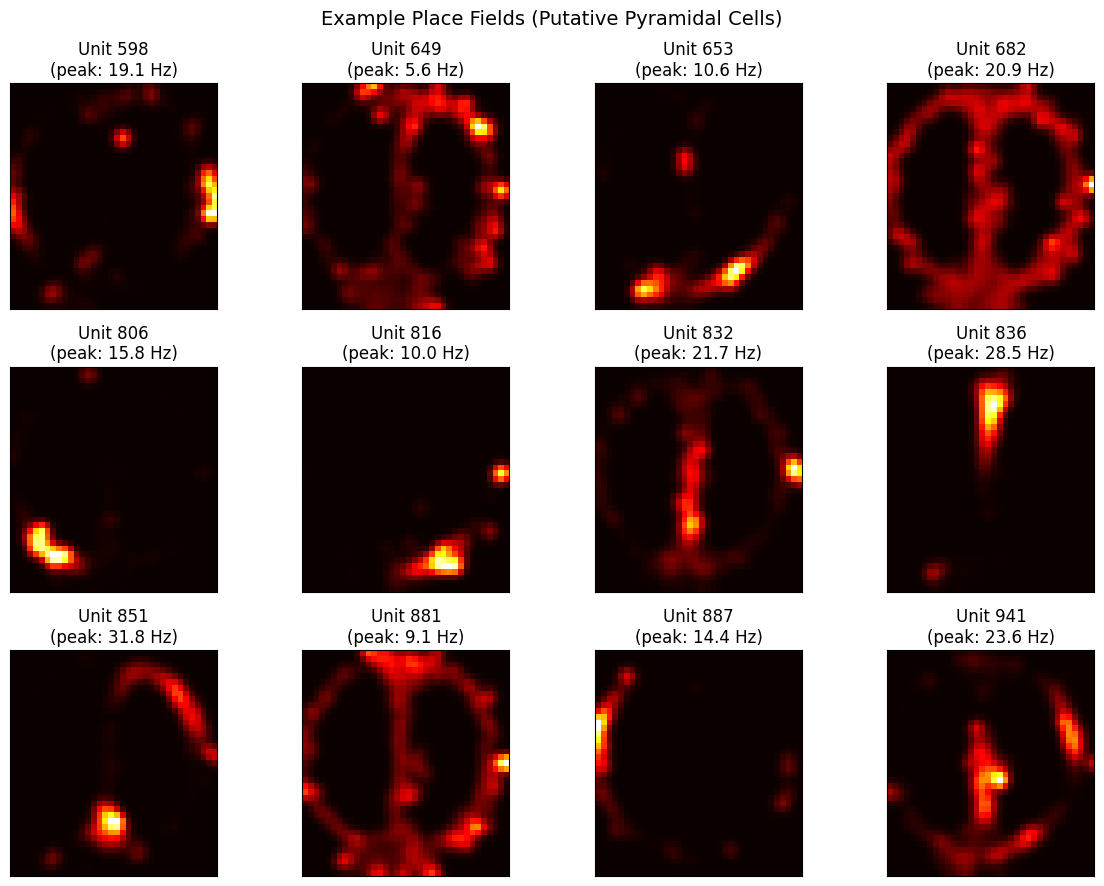

In [14]:
# Plot example place fields
n_examples = min(12, len(spike_times_all))
fig, axes = plt.subplots(3, 4, figsize=(12, 9), layout="constrained")

for i, ax in enumerate(axes.flat[:n_examples]):
    im = ax.imshow(
        place_fields_smooth[i].T,
        origin="lower",
        extent=[min_x, max_x, min_y, max_y],
        cmap="hot",
        aspect="equal",
    )
    ax.set_title(f"Unit {unit_indices_final[i]}\n(peak: {peak_rates_filtered[i]:.1f} Hz)")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide empty subplots
for ax in axes.flat[n_examples:]:
    ax.axis("off")

fig.suptitle("Example Place Fields (Putative Pyramidal Cells)", fontsize=14)

## Part 2: The Bayesian Decoding Algorithm

Now we have the encoding model: for each neuron, we know its expected firing
rate $f_i(x)$ at every position $x$. The decoding problem is to invert this:
given observed spike counts, what is the most likely position?

### Bayes' Theorem for Decoding

We want the **posterior probability** of position given spikes:

$$P(\text{position} \mid \text{spikes}) = \frac{P(\text{spikes} \mid \text{position}) \cdot P(\text{position})}{P(\text{spikes})}$$

Where:
- $P(\text{spikes} \mid \text{position})$ is the **likelihood** - how probable
  are the observed spikes if the animal is at this position?
- $P(\text{position})$ is the **prior** - what do we expect about position
  before seeing the spikes? (Often uniform or based on occupancy)
- $P(\text{spikes})$ is the **evidence** - a normalizing constant

### The Poisson Likelihood for Multiple Neurons

If we observe spike counts $n_1, n_2, \ldots, n_N$ from $N$ neurons in a time
bin, and the neurons fire independently, the joint likelihood is the product
of individual Poisson likelihoods:

$$P(n_1, n_2, \ldots, n_N \mid x) = \prod_{i=1}^{N} \frac{\lambda_i(x)^{n_i} e^{-\lambda_i(x)}}{n_i!}$$

where $\lambda_i(x) = f_i(x) \cdot \Delta t$ is the expected spike count for
neuron $i$ at position $x$.

### Simplifying the Likelihood

Taking the log (which we'll need for numerical stability):

$$\log P(\mathbf{n} \mid x) = \sum_{i=1}^{N} \left[ n_i \log \lambda_i(x) - \lambda_i(x) - \log(n_i!) \right]$$

The $\log(n_i!)$ terms don't depend on position, so for finding the maximum
likelihood position, we only need:

$$\log P(\mathbf{n} \mid x) \propto \sum_{i=1}^{N} \left[ n_i \log f_i(x) - f_i(x) \cdot \Delta t \right]$$

This is the core computation of the decoder.

### Understanding the Likelihood Components

Let's break down what each term means:

1. **$n_i \log f_i(x)$**: Contribution from observed spikes
   - If neuron $i$ fired ($n_i > 0$), positions with high $f_i(x)$ are favored
   - This is how spikes "vote" for their neuron's place field

2. **$-f_i(x) \cdot \Delta t$**: Penalty for expected spikes
   - Positions with high expected rates are penalized
   - This prevents bias toward high-rate regions

The balance between these terms is crucial:
- Observing a spike from neuron $i$ increases the likelihood at positions
  where neuron $i$ has a high firing rate
- But we must also account for the *expected* number of spikes everywhere

## Part 3: Implementing the Decoder

In [15]:
# Define time binning for decoding
TIME_BIN_SIZE = 0.025  # 25 ms bins (same as Week 2b)

# Create time bins covering the position tracking epoch
time_bin_edges = np.arange(
    position_timestamps.min(), position_timestamps.max() + TIME_BIN_SIZE, TIME_BIN_SIZE
)
time_bin_centers = time_bin_edges[:-1] + TIME_BIN_SIZE / 2
n_time_bins = len(time_bin_centers)

print(f"Number of time bins: {n_time_bins}")
print(f"Time bin size: {TIME_BIN_SIZE * 1000:.0f} ms")

Number of time bins: 66218
Time bin size: 25 ms


In [16]:
def bin_spikes(
    spike_times_list: list[NDArray[np.floating]], bin_edges: NDArray[np.floating]
) -> NDArray[np.int32]:
    """Bin spike times into counts for each neuron and time bin.

    Parameters
    ----------
    spike_times_list : list of np.ndarray
        Spike times for each neuron
    bin_edges : np.ndarray
        Time bin edges

    Returns
    -------
    np.ndarray
        Spike counts, shape (n_neurons, n_time_bins)
    """
    n_neurons = len(spike_times_list)
    n_bins = len(bin_edges) - 1
    spike_counts = np.zeros((n_neurons, n_bins), dtype=np.int32)

    for i, spikes in enumerate(spike_times_list):
        counts, _ = np.histogram(spikes, bins=bin_edges)
        spike_counts[i] = counts

    return spike_counts


# Bin spikes for all neurons
spike_counts = bin_spikes(spike_times_all, time_bin_edges)
print(f"Spike counts shape: {spike_counts.shape}")
print(f"Total spikes: {spike_counts.sum()}")

Spike counts shape: (82, 66218)
Total spikes: 239067


In [17]:
# Get true position at each time bin center (for evaluation)
true_x = np.interp(time_bin_centers, position_timestamps, x_position)
true_y = np.interp(time_bin_centers, position_timestamps, y_position)

### The Core Decoding Function

Now we implement the log-likelihood calculation. For each time bin, we compute
the log-likelihood of each possible position given the observed spike counts.

In [18]:
def compute_log_likelihood(
    spike_counts: NDArray[np.int32],
    place_fields: NDArray[np.floating],
    time_bin_size: float,
) -> NDArray[np.floating]:
    """Compute log-likelihood of each position for each time bin.

    Parameters
    ----------
    spike_counts : np.ndarray
        Spike counts, shape (n_neurons, n_time_bins)
    place_fields : np.ndarray
        Firing rate maps, shape (n_neurons, n_x_bins, n_y_bins)
    time_bin_size : float
        Duration of each time bin in seconds

    Returns
    -------
    np.ndarray
        Log-likelihood, shape (n_time_bins, n_x_bins, n_y_bins)
    """
    n_neurons, n_time_bins = spike_counts.shape
    _, n_x_bins, n_y_bins = place_fields.shape

    # Expected spike counts: lambda = rate * dt
    expected_counts = place_fields * time_bin_size  # (n_neurons, n_x, n_y)

    # Add small constant to avoid log(0)
    # This is crucial for numerical stability!
    MIN_RATE = 1e-10
    expected_counts = np.maximum(expected_counts, MIN_RATE * time_bin_size)
    log_rates = np.log(expected_counts)

    # Initialize log-likelihood array
    log_likelihood = np.zeros((n_time_bins, n_x_bins, n_y_bins))

    # For each time bin, compute log-likelihood across all positions
    for t in range(n_time_bins):
        n = spike_counts[:, t]  # Spike counts for all neurons at time t

        # Sum over neurons:
        # log P(n|x) = sum_i [n_i * log(lambda_i(x)) - lambda_i(x)]
        # We ignore the log(n!) term as it doesn't depend on position

        # Term 1: n_i * log(lambda_i(x))
        # Expand n to broadcast: (n_neurons,) -> (n_neurons, 1, 1)
        spike_term = np.sum(n[:, np.newaxis, np.newaxis] * log_rates, axis=0)

        # Term 2: -lambda_i(x) (summed over neurons)
        rate_term = -np.sum(expected_counts, axis=0)

        log_likelihood[t] = spike_term + rate_term

    return log_likelihood

In [19]:
print("Computing log-likelihoods...")
log_likelihood = compute_log_likelihood(spike_counts, place_fields_smooth, TIME_BIN_SIZE)
print(f"Log-likelihood shape: {log_likelihood.shape}")

Computing log-likelihoods...
Log-likelihood shape: (66218, 36, 39)


### Converting to Posterior Probability

The log-likelihood gives us $\log P(\text{spikes} \mid \text{position})$.
To get the posterior, we need to:

1. Add a prior (we'll use uniform for simplicity)
2. Normalize so probabilities sum to 1

**Numerical stability**: The log-likelihoods can be very negative (large
negative numbers). To convert to probabilities without underflow:

1. Subtract the maximum log-likelihood (for each time bin)
2. Exponentiate
3. Normalize

In [20]:
def log_likelihood_to_posterior(
    log_likelihood: NDArray[np.floating],
    prior: NDArray[np.floating] | None = None,
) -> NDArray[np.floating]:
    """Convert log-likelihood to posterior probability.

    Parameters
    ----------
    log_likelihood : np.ndarray
        Log-likelihood, shape (n_time_bins, n_x_bins, n_y_bins)
    prior : np.ndarray, optional
        Prior probability over positions, shape (n_x_bins, n_y_bins)
        If None, uses uniform prior

    Returns
    -------
    np.ndarray
        Posterior probability, shape (n_time_bins, n_x_bins, n_y_bins)
    """
    n_time_bins, n_x_bins, n_y_bins = log_likelihood.shape

    # Add log prior (uniform = 0 in log space)
    if prior is not None:
        log_posterior = log_likelihood + np.log(prior + 1e-10)
    else:
        log_posterior = log_likelihood.copy()

    # Numerical stability: subtract max before exponentiating
    # This prevents underflow when log-likelihoods are very negative
    log_max = np.max(log_posterior, axis=(1, 2), keepdims=True)
    log_posterior_shifted = log_posterior - log_max

    # Exponentiate
    posterior = np.exp(log_posterior_shifted)

    # Normalize each time bin to sum to 1
    posterior_sum = np.sum(posterior, axis=(1, 2), keepdims=True)
    posterior = posterior / (posterior_sum + 1e-10)

    return posterior

In [21]:
# Compute posterior with uniform prior
posterior = log_likelihood_to_posterior(log_likelihood)
print(f"Posterior shape: {posterior.shape}")

# Verify normalization
print(f"Posterior sums (should be ~1): min={posterior.sum(axis=(1,2)).min():.6f}, "
      f"max={posterior.sum(axis=(1,2)).max():.6f}")

Posterior shape: (66218, 36, 39)
Posterior sums (should be ~1): min=1.000000, max=1.000000


### Decoding: Maximum A Posteriori (MAP) Estimate

The **maximum a posteriori (MAP)** estimate is the position with highest
posterior probability:

$$\hat{x} = \arg\max_x P(x \mid \text{spikes})$$

With a uniform prior, MAP is equivalent to **maximum likelihood (ML)**:

$$\hat{x}_{ML} = \arg\max_x P(\text{spikes} \mid x)$$

This connection is important: Bayesian decoding with a uniform prior reduces
to finding the position that makes the observed spikes most probable.

In [22]:
def decode_map(
    posterior: NDArray[np.floating],
    x_centers: NDArray[np.floating],
    y_centers: NDArray[np.floating],
) -> tuple[NDArray[np.floating], NDArray[np.floating]]:
    """Decode position using maximum a posteriori estimate.

    Parameters
    ----------
    posterior : np.ndarray
        Posterior probability, shape (n_time_bins, n_x_bins, n_y_bins)
    x_centers, y_centers : np.ndarray
        Bin centers for each dimension

    Returns
    -------
    decoded_x, decoded_y : np.ndarray
        Decoded position coordinates
    """
    n_time_bins = posterior.shape[0]

    # Find the bin with maximum posterior probability
    # Flatten spatial dimensions, find argmax, then convert back to 2D indices
    flat_posterior = posterior.reshape(n_time_bins, -1)
    max_idx = np.argmax(flat_posterior, axis=1)

    # Convert flat index to 2D indices
    n_y = len(y_centers)
    x_idx = max_idx // n_y
    y_idx = max_idx % n_y

    # Get coordinates at maximum
    decoded_x = x_centers[x_idx]
    decoded_y = y_centers[y_idx]

    return decoded_x, decoded_y

In [23]:
# Decode position
decoded_x, decoded_y = decode_map(posterior, x_bin_centers, y_bin_centers)
print(f"Decoded {len(decoded_x)} time bins")

Decoded 66218 time bins


## Part 4: Understanding the Role of No-Spike Bins

A crucial insight in Bayesian decoding: **time bins with no spikes still carry
information!**

When a neuron doesn't spike in a time bin, this is evidence *against* being
in that neuron's place field. The $-\lambda_i(x)$ term in the log-likelihood
implements this:

- If the animal were in neuron $i$'s place field, we'd *expect* spikes
- Not seeing spikes makes that location less likely

This is why the decoder can still work reasonably well even in bins with
few or no spikes - silence is informative!

In [24]:
# Analyze spike counts per time bin
total_spikes_per_bin = spike_counts.sum(axis=0)

print("Spike count distribution across time bins:")
print(f"  Mean: {total_spikes_per_bin.mean():.2f}")
print(f"  Median: {np.median(total_spikes_per_bin):.0f}")
print(f"  Max: {total_spikes_per_bin.max()}")
print(f"  Bins with 0 spikes: {(total_spikes_per_bin == 0).sum()} "
      f"({100*(total_spikes_per_bin == 0).mean():.1f}%)")

Spike count distribution across time bins:
  Mean: 3.61
  Median: 3
  Max: 38
  Bins with 0 spikes: 11653 (17.6%)


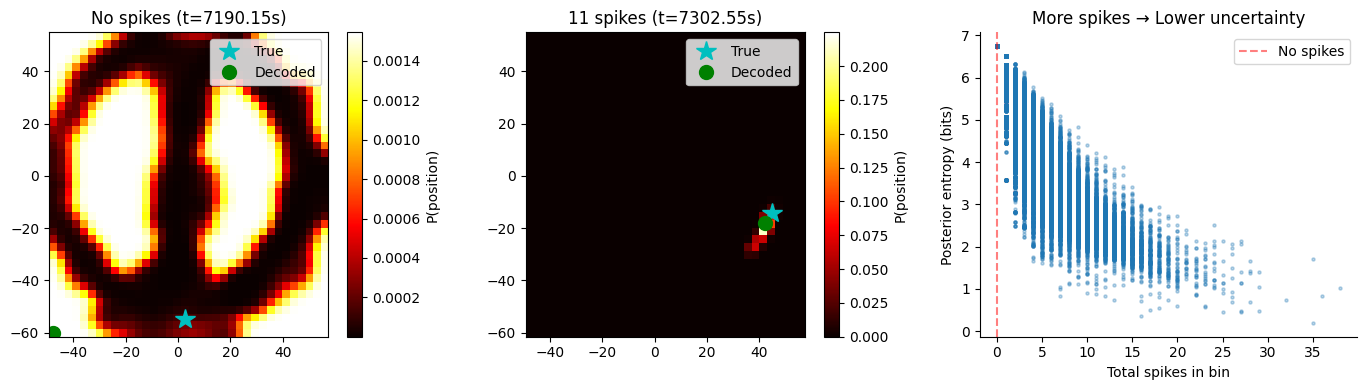

In [25]:
# Visualize posterior for a bin with no spikes vs bin with many spikes
fig, axes = plt.subplots(1, 3, figsize=(14, 4), layout="constrained")

# Find examples
no_spike_bins = np.where(total_spikes_per_bin == 0)[0]
many_spike_bins = np.where(total_spikes_per_bin >= 10)[0]

if len(no_spike_bins) > 0:
    t_no_spike = no_spike_bins[len(no_spike_bins) // 2]  # Middle example
else:
    t_no_spike = 0

t_many_spike = many_spike_bins[len(many_spike_bins) // 2]

# No spike bin
ax = axes[0]
im = ax.imshow(
    posterior[t_no_spike].T,
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
    cmap="hot",
    aspect="equal",
)
ax.plot(true_x[t_no_spike], true_y[t_no_spike], "c*", markersize=15, label="True")
ax.plot(decoded_x[t_no_spike], decoded_y[t_no_spike], "go", markersize=10, label="Decoded")
ax.set_title(f"No spikes (t={time_bin_centers[t_no_spike]:.2f}s)")
ax.legend(loc="upper right")
fig.colorbar(im, ax=ax, label="P(position)")

# Many spike bin
ax = axes[1]
im = ax.imshow(
    posterior[t_many_spike].T,
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
    cmap="hot",
    aspect="equal",
)
ax.plot(true_x[t_many_spike], true_y[t_many_spike], "c*", markersize=15, label="True")
ax.plot(decoded_x[t_many_spike], decoded_y[t_many_spike], "go", markersize=10, label="Decoded")
ax.set_title(f"{total_spikes_per_bin[t_many_spike]} spikes (t={time_bin_centers[t_many_spike]:.2f}s)")
ax.legend(loc="upper right")
fig.colorbar(im, ax=ax, label="P(position)")

# Show the difference in posterior "sharpness"
ax = axes[2]
# Compute entropy as measure of uncertainty
posterior_flat = posterior.reshape(len(posterior), -1)
with np.errstate(divide="ignore", invalid="ignore"):
    entropy = -np.sum(posterior_flat * np.log(posterior_flat + 1e-10), axis=1)

ax.scatter(total_spikes_per_bin, entropy, alpha=0.3, s=5)
ax.axvline(0, color="red", linestyle="--", alpha=0.5, label="No spikes")
ax.set(xlabel="Total spikes in bin", ylabel="Posterior entropy (bits)", title="More spikes → Lower uncertainty")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

### The No-Spike Posterior and Place Field Coverage

When there are no spikes in a time bin, the log-likelihood becomes:

$$\log P(\text{no spikes} \mid x) = -\sum_{i=1}^{N} \lambda_i(x) = -\Delta t \sum_{i=1}^{N} f_i(x)$$

This means the posterior for no-spike bins is:

$$P(x \mid \text{no spikes}) \propto \exp\left(-\Delta t \sum_{i=1}^{N} f_i(x)\right)$$

**Key insight**: Positions with high total firing rate are *less* likely when
no spikes are observed. The decoder infers the animal is probably somewhere
with low expected activity.

**Place field coverage matters**: If place fields don't cover the entire
environment, regions without place fields will have high posterior probability
during no-spike bins - which may or may not be correct!

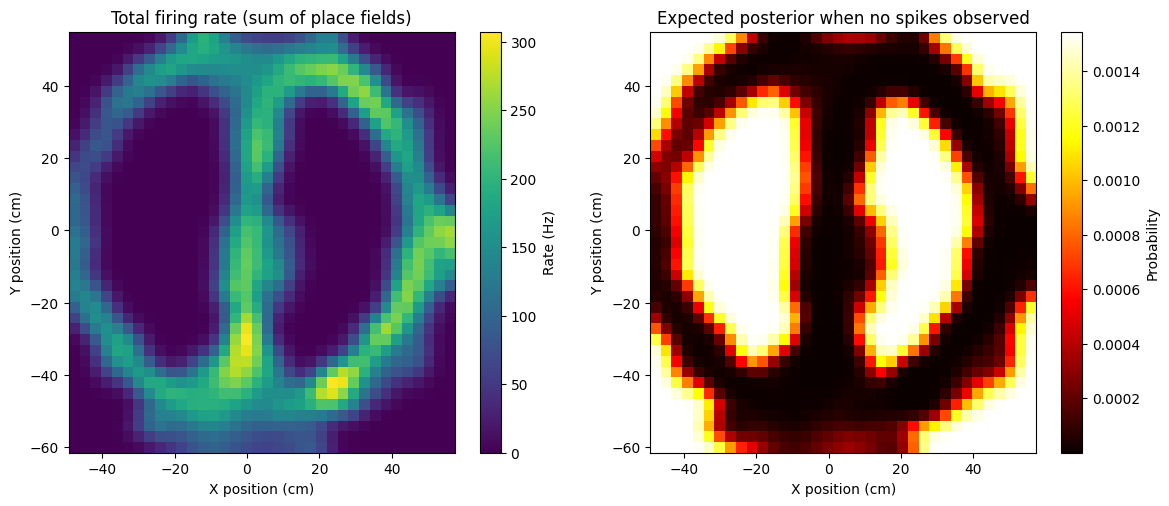

In [26]:
# Visualize total firing rate across space (sum of all place fields)
total_rate_map = np.sum(place_fields_smooth, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

ax = axes[0]
im = ax.imshow(
    total_rate_map.T,
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
    cmap="viridis",
    aspect="equal",
)
ax.set(xlabel="X position (cm)", ylabel="Y position (cm)", title="Total firing rate (sum of place fields)")
fig.colorbar(im, ax=ax, label="Rate (Hz)")

# Predicted posterior for no-spike bin (negative of total rate)
ax = axes[1]
no_spike_prior = np.exp(-TIME_BIN_SIZE * total_rate_map)
no_spike_prior = no_spike_prior / no_spike_prior.sum()
im = ax.imshow(
    no_spike_prior.T,
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
    cmap="hot",
    aspect="equal",
)
ax.set(xlabel="X position (cm)", ylabel="Y position (cm)", title="Expected posterior when no spikes observed")
fig.colorbar(im, ax=ax, label="Probability")

## Part 5: Numerical Stability in Detail

Computing products of many small probabilities is numerically dangerous.
Consider decoding with 100 neurons over a 25 ms bin:

$$P(\mathbf{n} \mid x) = \prod_{i=1}^{100} \frac{\lambda_i^{n_i} e^{-\lambda_i}}{n_i!}$$

Even if each factor is 0.1, the product is $10^{-100}$ - below floating point
precision! This is why we work in log space.

### The Log-Sum-Exp Trick

When converting back from log-likelihood to probabilities, we use:

$$P(x) = \frac{\exp(\log L(x))}{\sum_{x'} \exp(\log L(x'))}$$

The denominator involves summing exponentials of potentially large negative
numbers. The **log-sum-exp trick** handles this by shifting all values:

$$\log \sum_i e^{a_i} = \max(a) + \log \sum_i e^{a_i - \max(a)}$$

After shifting, the largest exponent is 0, preventing underflow.

In [27]:
# Demonstrate the numerical issue
print("Numerical stability demonstration:")
print("-" * 50)

# Simulate a problematic case: many small probabilities
n_neurons_demo = 100
small_prob = 0.1

# Direct multiplication (problematic)
direct_product = small_prob ** n_neurons_demo
print(f"Direct product of {n_neurons_demo} factors of {small_prob}:")
print(f"  Result: {direct_product}")  # Underflows to 0!

# Log-space computation (stable)
log_sum = n_neurons_demo * np.log(small_prob)
print(f"\nLog-space computation:")
print(f"  log(product) = {log_sum:.1f}")
print(f"  This is a valid, finite number we can work with")

# Show how log-sum-exp works
print(f"\nLog-sum-exp trick example:")
log_values = np.array([-500, -501, -502, -600])
print(f"  Log values: {log_values}")

# Naive approach fails
naive_sum = np.sum(np.exp(log_values))
print(f"  Naive exp then sum: {naive_sum}")  # 0.0 due to underflow

# Log-sum-exp approach works
max_log = np.max(log_values)
stable_sum = np.exp(max_log) * np.sum(np.exp(log_values - max_log))
log_of_sum = max_log + np.log(np.sum(np.exp(log_values - max_log)))
print(f"  Log-sum-exp result (log of sum): {log_of_sum:.2f}")

Numerical stability demonstration:
--------------------------------------------------
Direct product of 100 factors of 0.1:
  Result: 1.0000000000000056e-100

Log-space computation:
  log(product) = -230.3
  This is a valid, finite number we can work with

Log-sum-exp trick example:
  Log values: [-500 -501 -502 -600]
  Naive exp then sum: 1.0709768159783733e-217
  Log-sum-exp result (log of sum): -499.59


## Part 6: Evaluating Decoder Performance

In [28]:
# Compute decoding error
# Note: true positions may have NaN where tracking was lost
error = np.sqrt((decoded_x - true_x) ** 2 + (decoded_y - true_y) ** 2)

# Mask for valid (non-NaN) positions
valid_mask = ~np.isnan(error)
error_valid = error[valid_mask]

print("Decoding error statistics:")
print(f"  Valid time bins: {valid_mask.sum()} / {len(error)} ({100*valid_mask.mean():.1f}%)")
print(f"  Mean error: {np.mean(error_valid):.1f} cm")
print(f"  Median error: {np.median(error_valid):.1f} cm")
print(f"  90th percentile: {np.percentile(error_valid, 90):.1f} cm")

Decoding error statistics:
  Valid time bins: 65879 / 66218 (99.5%)
  Mean error: 40.4 cm
  Median error: 35.6 cm
  90th percentile: 94.3 cm


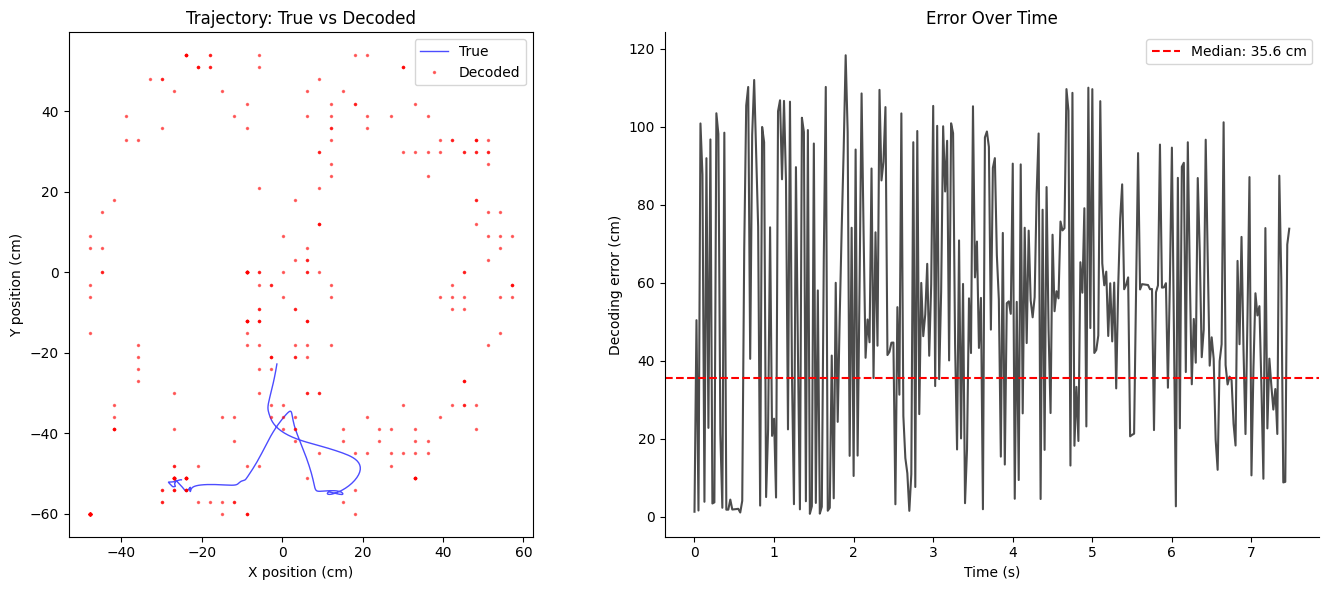

In [29]:
# Visualize decoded vs true trajectory
fig, axes = plt.subplots(1, 2, figsize=(14, 6), layout="constrained")

# Time window for visualization
t_start, t_end = 100, 400  # Indices
time_window = slice(t_start, t_end)

ax = axes[0]
ax.plot(true_x[time_window], true_y[time_window], "b-", alpha=0.7, linewidth=1, label="True")
ax.plot(decoded_x[time_window], decoded_y[time_window], "r.", alpha=0.5, markersize=3, label="Decoded")
ax.set(xlabel="X position (cm)", ylabel="Y position (cm)", title="Trajectory: True vs Decoded")
ax.legend()
ax.set_aspect("equal")
ax.spines[["top", "right"]].set_visible(False)

# Error over time
ax = axes[1]
time_slice = time_bin_centers[time_window]
ax.plot(time_slice - time_slice[0], error[time_window], "k-", alpha=0.7)
ax.axhline(np.median(error_valid), color="red", linestyle="--", label=f"Median: {np.median(error_valid):.1f} cm")
ax.set(xlabel="Time (s)", ylabel="Decoding error (cm)", title="Error Over Time")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

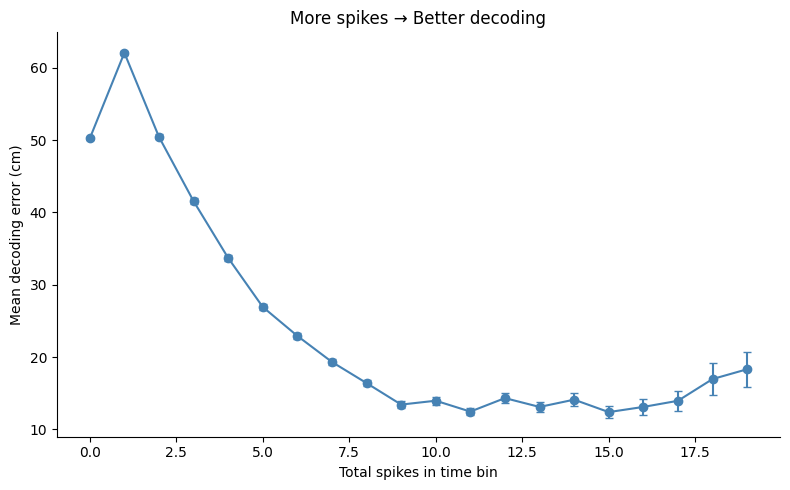

In [30]:
# Error as a function of spike count
fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")

# Bin by spike count
spike_count_bins = np.arange(0, 20)
mean_error_by_spikes = []
se_error_by_spikes = []

for n_spikes in spike_count_bins:
    mask = (total_spikes_per_bin == n_spikes) & valid_mask
    if mask.sum() > 10:
        mean_error_by_spikes.append(np.nanmean(error[mask]))
        se_error_by_spikes.append(np.nanstd(error[mask]) / np.sqrt(mask.sum()))
    else:
        mean_error_by_spikes.append(np.nan)
        se_error_by_spikes.append(np.nan)

valid = ~np.isnan(mean_error_by_spikes)
ax.errorbar(
    spike_count_bins[valid],
    np.array(mean_error_by_spikes)[valid],
    yerr=np.array(se_error_by_spikes)[valid],
    fmt="o-",
    capsize=3,
    color="steelblue",
)
ax.set(xlabel="Total spikes in time bin", ylabel="Mean decoding error (cm)", title="More spikes → Better decoding")
ax.spines[["top", "right"]].set_visible(False)

## Part 7: Effect of Time Bin Size

The choice of time bin size $\Delta t$ represents a fundamental tradeoff:

**Smaller bins (e.g., 10 ms):**
- Higher temporal resolution - can track fast movements
- Fewer spikes per bin → higher variance in estimates
- More bins with zero spikes → rely on "silence is informative"

**Larger bins (e.g., 100 ms):**
- More spikes per bin → lower variance
- Lower temporal resolution - can't track fast movements
- The animal may move significantly within a bin, blurring the estimate

This is the classic **bias-variance tradeoff**: small bins have low bias but
high variance; large bins have low variance but may miss rapid dynamics.

### Implications for Neural Coding

The optimal bin size reveals something about the neural code:
- If 10 ms bins work well, information is encoded on fast timescales
- If 100 ms bins are needed, the code integrates over longer periods

For hippocampal place cells during running, the theta rhythm (~8 Hz, 125 ms
period) provides a natural timescale. Decoding often works best around
25-50 ms, capturing within-theta-cycle dynamics.

In [31]:
# Compare different bin sizes
bin_sizes = [0.010, 0.025, 0.050, 0.100, 0.200]  # seconds

results_by_binsize = []

print("Evaluating different bin sizes...")
for bin_size in bin_sizes:
    # Bin spikes
    edges = np.arange(
        position_timestamps.min(),
        position_timestamps.max() + bin_size,
        bin_size,
    )
    centers = edges[:-1] + bin_size / 2

    counts = bin_spikes(spike_times_all, edges)

    # Compute log-likelihood and posterior
    ll = compute_log_likelihood(counts, place_fields_smooth, bin_size)
    post = log_likelihood_to_posterior(ll)

    # Decode
    dec_x, dec_y = decode_map(post, x_bin_centers, y_bin_centers)

    # True positions at bin centers
    tx = np.interp(centers, position_timestamps, x_position)
    ty = np.interp(centers, position_timestamps, y_position)

    # Compute error (filter out NaN positions)
    err = np.sqrt((dec_x - tx) ** 2 + (dec_y - ty) ** 2)
    err_valid = err[~np.isnan(err)]

    # Store results
    results_by_binsize.append({
        "bin_size_ms": bin_size * 1000,
        "n_bins": len(centers),
        "mean_spikes_per_bin": counts.sum(axis=0).mean(),
        "mean_error": np.mean(err_valid),
        "median_error": np.median(err_valid),
    })

    print(f"  {bin_size*1000:4.0f} ms: mean error = {np.mean(err_valid):.1f} cm, "
          f"median = {np.median(err_valid):.1f} cm, "
          f"spikes/bin = {counts.sum(axis=0).mean():.1f}")

Evaluating different bin sizes...
    10 ms: mean error = nan cm, median = nan cm, spikes/bin = 1.4
    25 ms: mean error = nan cm, median = nan cm, spikes/bin = 3.6
    50 ms: mean error = nan cm, median = nan cm, spikes/bin = 7.2
   100 ms: mean error = nan cm, median = nan cm, spikes/bin = 14.4
   200 ms: mean error = nan cm, median = nan cm, spikes/bin = 28.9


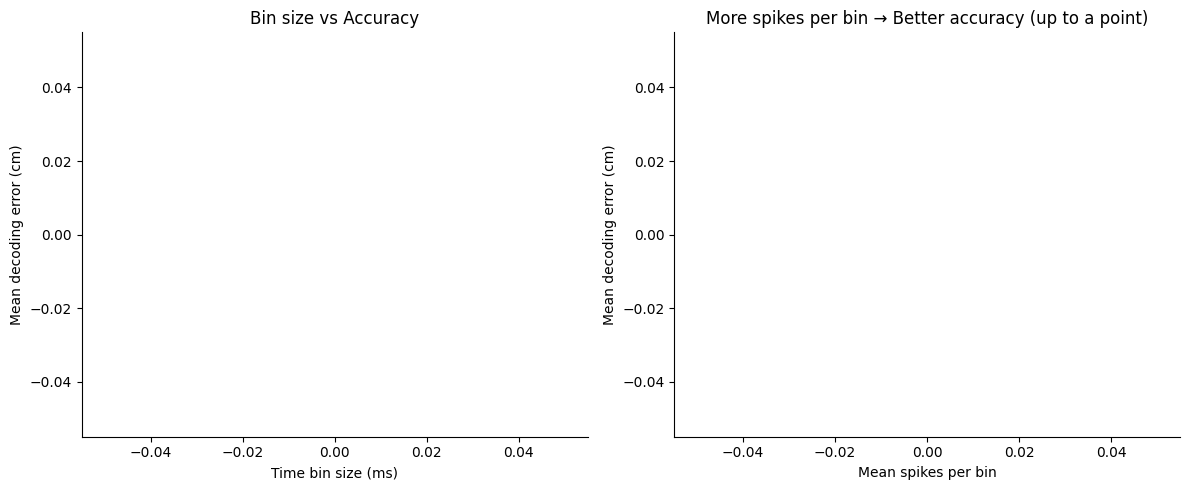

In [32]:
# Visualize bin size effect
fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

bin_sizes_ms = [r["bin_size_ms"] for r in results_by_binsize]
mean_errors = [r["mean_error"] for r in results_by_binsize]
spikes_per_bin = [r["mean_spikes_per_bin"] for r in results_by_binsize]

ax = axes[0]
ax.plot(bin_sizes_ms, mean_errors, "o-", color="steelblue", markersize=8)
ax.set(xlabel="Time bin size (ms)", ylabel="Mean decoding error (cm)", title="Bin size vs Accuracy")
ax.spines[["top", "right"]].set_visible(False)

ax = axes[1]
ax.plot(spikes_per_bin, mean_errors, "o-", color="steelblue", markersize=8)
for i, (x, y, ms) in enumerate(zip(spikes_per_bin, mean_errors, bin_sizes_ms)):
    ax.annotate(f"{ms:.0f}ms", (x, y), textcoords="offset points", xytext=(5, 5))
ax.set(xlabel="Mean spikes per bin", ylabel="Mean decoding error (cm)", title="More spikes per bin → Better accuracy (up to a point)")
ax.spines[["top", "right"]].set_visible(False)

## Part 8: Maximum Likelihood vs Bayesian Decoding

We've been using a **uniform prior**, which makes Bayesian decoding equivalent
to maximum likelihood. But we could use an **informative prior** based on:

1. **Occupancy prior**: More likely to be where the animal spends more time
2. **Continuity prior**: Position shouldn't jump too far between time bins
3. **Behavioral prior**: Constrain to valid locations (on the track)

### Using an Occupancy Prior

In [33]:
# Create occupancy-based prior (with safety check for zero occupancy)
if occupancy.sum() > 0:
    occupancy_prior = occupancy / occupancy.sum()
else:
    # Fallback to uniform if no valid occupancy data
    occupancy_prior = np.ones_like(occupancy) / occupancy.size

# Decode with occupancy prior
posterior_with_prior = log_likelihood_to_posterior(log_likelihood, prior=occupancy_prior)
decoded_x_prior, decoded_y_prior = decode_map(
    posterior_with_prior, x_bin_centers, y_bin_centers
)

# Compute error (use same valid_mask as uniform prior for fair comparison)
error_with_prior = np.sqrt(
    (decoded_x_prior - true_x) ** 2 + (decoded_y_prior - true_y) ** 2
)
error_with_prior_valid = error_with_prior[valid_mask]

print("Comparison: Uniform vs Occupancy prior")
print(f"  Uniform prior - Mean error: {np.mean(error_valid):.1f} cm, Median: {np.median(error_valid):.1f} cm")
print(f"  Occupancy prior - Mean error: {np.mean(error_with_prior_valid):.1f} cm, "
      f"Median: {np.median(error_with_prior_valid):.1f} cm")

Comparison: Uniform vs Occupancy prior
  Uniform prior - Mean error: nan cm, Median: nan cm
  Occupancy prior - Mean error: nan cm, Median: nan cm


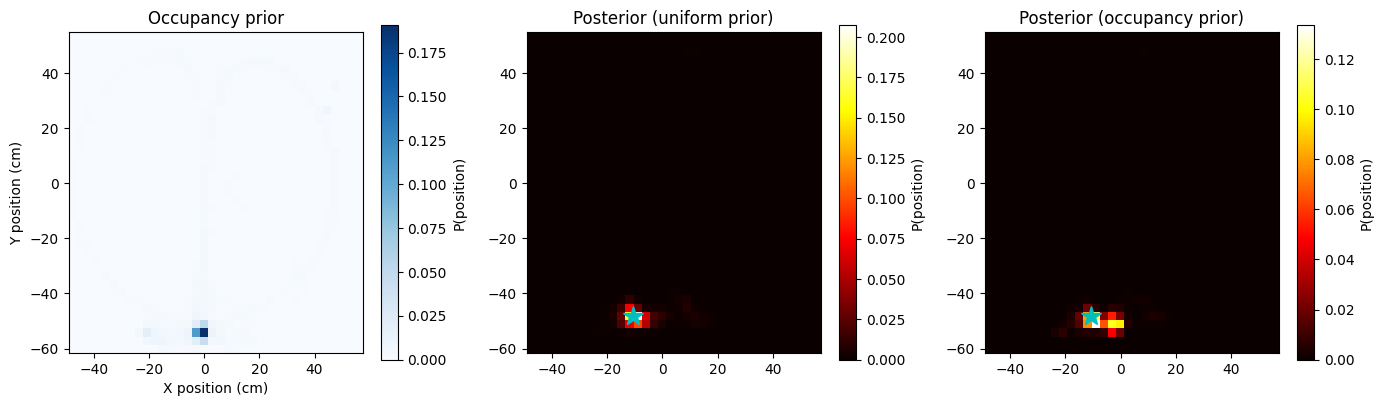

In [34]:
# Visualize the difference
fig, axes = plt.subplots(1, 3, figsize=(14, 4), layout="constrained")

# Show the prior
ax = axes[0]
im = ax.imshow(
    occupancy_prior.T,
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
    cmap="Blues",
    aspect="equal",
)
ax.set(xlabel="X position (cm)", ylabel="Y position (cm)", title="Occupancy prior")
fig.colorbar(im, ax=ax, label="P(position)")

# Example posterior with uniform prior
t_example = many_spike_bins[0]
ax = axes[1]
im = ax.imshow(
    posterior[t_example].T,
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
    cmap="hot",
    aspect="equal",
)
ax.plot(true_x[t_example], true_y[t_example], "c*", markersize=15)
ax.set_title("Posterior (uniform prior)")
fig.colorbar(im, ax=ax, label="P(position)")

# Same time bin with occupancy prior
ax = axes[2]
im = ax.imshow(
    posterior_with_prior[t_example].T,
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
    cmap="hot",
    aspect="equal",
)
ax.plot(true_x[t_example], true_y[t_example], "c*", markersize=15)
ax.set_title("Posterior (occupancy prior)")
fig.colorbar(im, ax=ax, label="P(position)")

## Summary

In this notebook, we learned how to:

1. **Build an encoding model** using histogram-based place field estimation
2. **Implement Bayesian decoding** using the Poisson likelihood
3. **Handle numerical stability** with log-space computations
4. **Understand no-spike bins** and how silence carries information
5. **Evaluate decoder performance** as a function of spike count
6. **Appreciate the bin size tradeoff** between resolution and reliability
7. **Compare maximum likelihood and Bayesian approaches** with different priors

### Key Concepts

| Concept | Description |
|---------|-------------|
| Encoding model | Maps position → firing rate (place fields) |
| Decoding | Maps neural activity → position estimate |
| Poisson likelihood | $P(n \mid \lambda) = \lambda^n e^{-\lambda} / n!$ |
| Log-likelihood | Sum of $n_i \log \lambda_i - \lambda_i$ over neurons |
| MAP estimate | Position with highest posterior probability |
| No-spike information | Absence of spikes rules out place field locations |
| Bin size tradeoff | Small = high variance; Large = low resolution |

### The Decoding Algorithm

```
For each time bin t:
    For each position x:
        log_likelihood[x] = sum over neurons i:
            n_i[t] * log(rate_i[x] * dt) - rate_i[x] * dt

    posterior = normalize(exp(log_likelihood - max(log_likelihood)))
    decoded_position = argmax(posterior)
```

### Python Techniques Used

- **Broadcasting** for efficient array operations across neurons and positions
- **Log-space arithmetic** for numerical stability
- **Gaussian smoothing** (`scipy.ndimage.gaussian_filter`) for rate maps
- **`np.errstate`** for suppressing divide-by-zero warnings

### Next Steps

In Week 5, we'll explore **clusterless decoding**, which bypasses spike sorting
entirely and decodes directly from spike waveform features. This approach can
capture information from neurons that are difficult to isolate.

## Exercises

Try these on your own to deepen your understanding:

1. **Effect of smoothing**: Try different values of `SMOOTHING_SIGMA` (0, 0.5, 2, 5).
   How does this affect decoding accuracy? Why?

2. **Subset of neurons**: Decode using only the top 20 neurons by peak rate.
   How does accuracy compare to using all neurons?

3. **Shuffled controls**: Shuffle the spike-position relationship by circularly
   shifting spike times. How does this affect accuracy?

4. **1D decoding**: This is a linear track. Project to 1D (just x-position) and
   decode. Is 1D decoding easier or harder?

5. **Prediction confidence**: Use the posterior entropy to identify time bins
   where the decoder is uncertain. Are these bins actually decoded worse?

6. **Cross-validation**: Split the data into training and test sets. Estimate
   place fields on training data and decode test data. Does this change accuracy?

7. **Continuity constraint**: Implement a simple continuity prior that penalizes
   large jumps between consecutive decoded positions.

## Cleanup

In [35]:
io.close()